## Topic Modeling: Latent Dirichlet Allocation with sklearn

### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import joblib

In [3]:
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14.0, 8.7)

In [4]:
pyLDAvis.enable_notebook()

In [5]:
# change to your data path if necessary
DATA_DIR = Path('../data')
data_path = DATA_DIR / 'bbc'

In [6]:
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

## Load BBC data

Using the BBC data as before, we use [sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to train an LDA model with five topics.

In [7]:
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [8]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

In [9]:
train_docs, test_docs = train_test_split(docs,
                                         stratify=docs.topic,
                                         test_size=125,
                                         random_state=42)

In [10]:
train_docs.shape, test_docs.shape

((2100, 3), (125, 3))

In [11]:
pd.Series(test_docs.topic).value_counts()

Business         29
Sport            29
Politics         23
Tech             22
Entertainment    22
Name: topic, dtype: int64

### Vectorize train & test sets

In [12]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2100x2936 sparse matrix of type '<class 'numpy.float64'>'
	with 198664 stored elements in Compressed Sparse Row format>

In [13]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<125x2936 sparse matrix of type '<class 'numpy.float64'>'
	with 11814 stored elements in Compressed Sparse Row format>

## LDA with sklearn

In [14]:
n_components = 5
topic_labels = [f'Topic {i}' for i in range(1, n_components+1)]

In [15]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

### Persist model

The model tracks the in-sample perplexity during training and stops iterating once this measure stops improving. We can persist and load the result as usual with sklearn objects:

In [16]:
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')

['results/bbc/lda_10_iter.pkl']

In [17]:
lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(n_components=5, n_jobs=-1)

## Explore topics & word distributions

In [18]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 2936)


array([[ 3.96878497,  4.40825693,  0.97030356, ...,  0.80585721,
         0.2000102 ,  4.80758959],
       [ 0.2000288 ,  0.20011304,  0.2001223 , ...,  0.20013723,
         0.20005885,  0.20018338],
       [ 0.20003764, 11.14464205,  7.55925814, ...,  1.70584108,
        10.4110306 ,  0.5481262 ],
       [ 0.20019415,  6.38187617,  2.06587474, ...,  1.1494619 ,
         0.20000931,  0.45045934],
       [ 0.2000288 ,  0.20011304,  0.2001223 , ...,  0.20013723,
         0.20005885,  0.20018338]])

In [19]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
000m,0.001013,0.000340,0.000020,0.000047,0.000340
10,0.001125,0.000341,0.001109,0.001496,0.000341
100,0.000248,0.000341,0.000752,0.000484,0.000341
100m,0.000415,0.000341,0.000144,0.000393,0.000341
11,0.000429,0.000341,0.000638,0.000934,0.000341


In [20]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

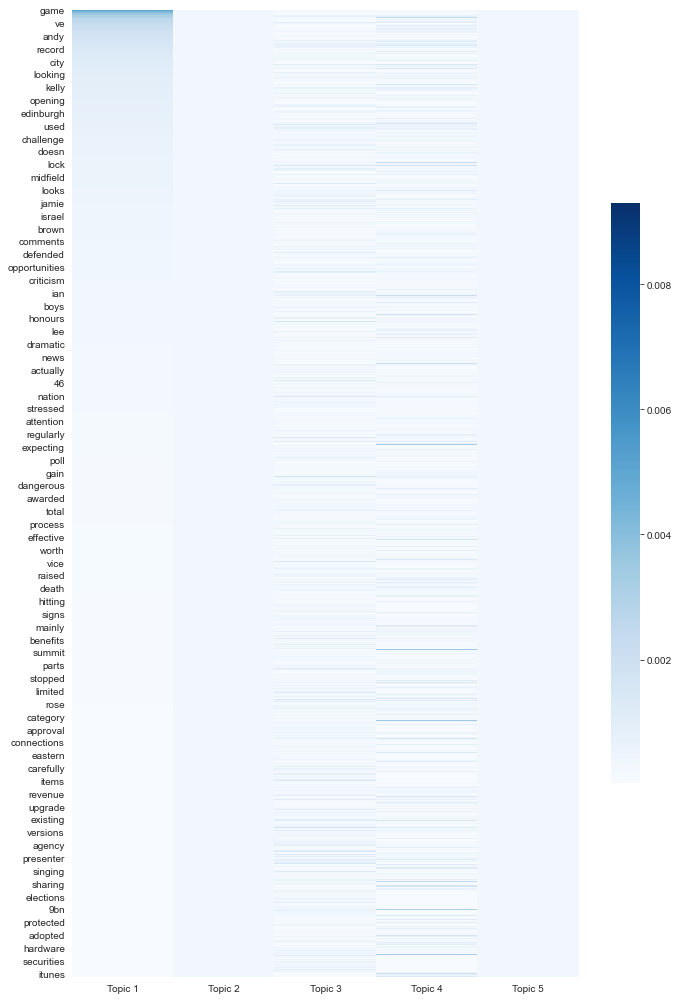

In [21]:
fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(topics.sort_values(topic_labels, ascending=False),
            cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
fig.tight_layout()

In [22]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,game,regime,labour,film,regime
1,england,veteran,election,music,veteran
2,win,walk,party,best,walk
3,club,stopped,blair,tv,stopped
4,match,milan,company,games,milan
5,cup,boys,market,awards,boys
6,team,mary,firm,award,mary
7,players,spokesperson,minister,band,spokesperson
8,play,finish,growth,video,finish
9,injury,7bn,economy,films,7bn


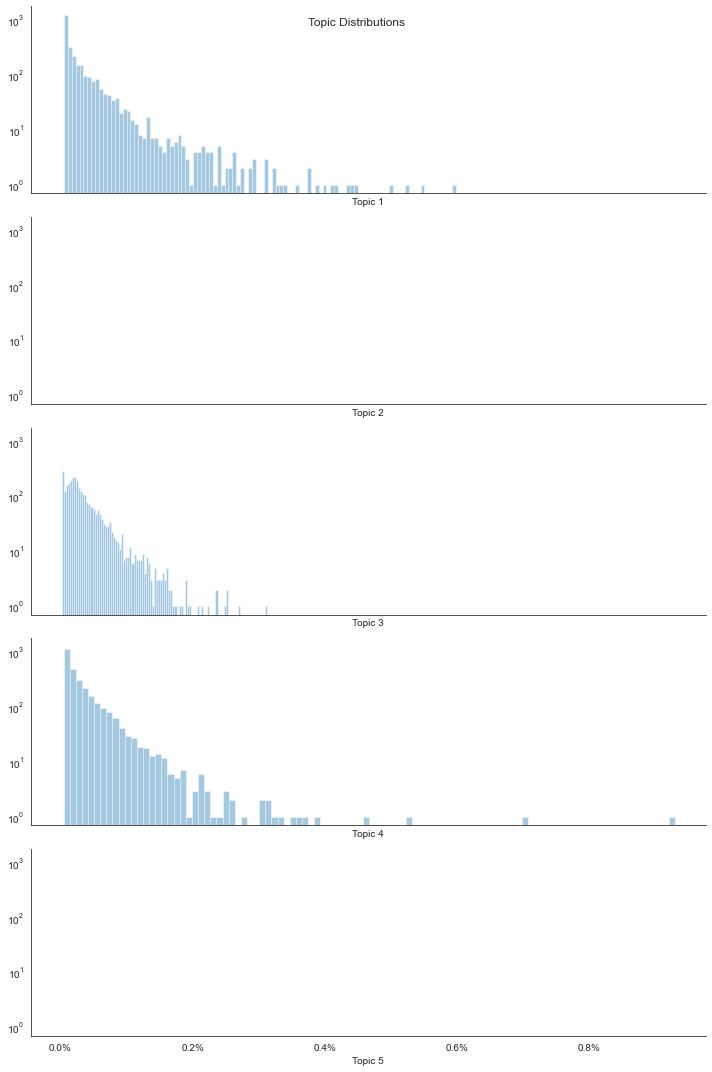

In [23]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
sns.despine()
fig.tight_layout()

## Evaluate Fit on Train Set

In [24]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2100, 5)

In [25]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Sport,0.907573,0.022907,0.023419,0.023194,0.022907
Tech,0.024088,0.023622,0.338494,0.590174,0.023622
Politics,0.019214,0.018115,0.926157,0.018399,0.018115
Sport,0.876242,0.030765,0.031157,0.031072,0.030765
Tech,0.021210,0.020403,0.186169,0.751815,0.020403


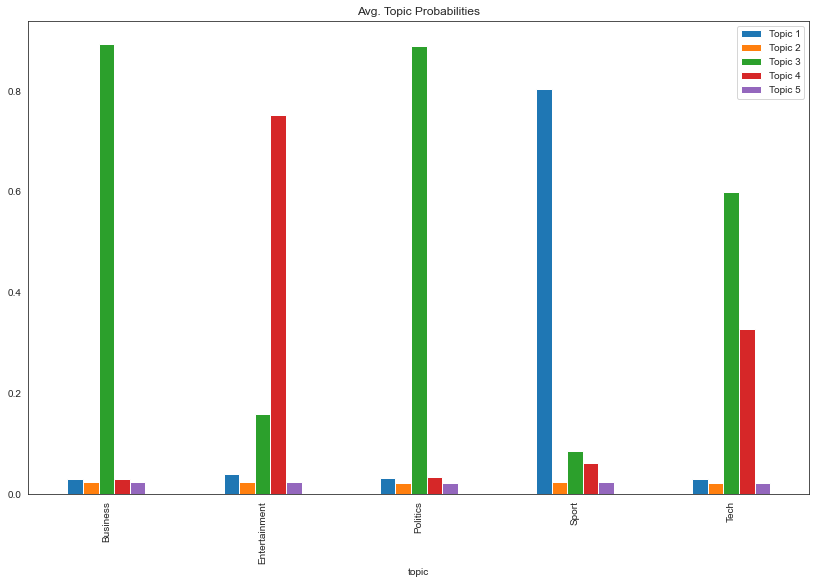

In [26]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

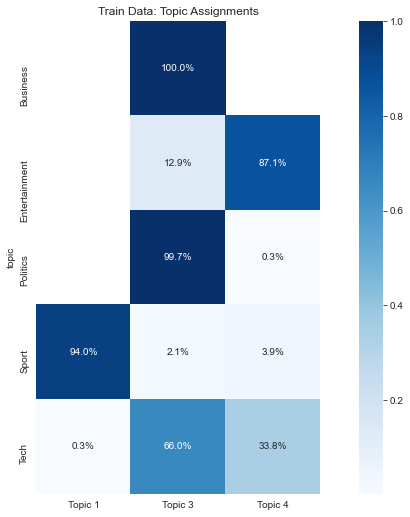

In [27]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

## Evaluate Fit on Test Set 

In [28]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Politics,0.017576,0.016811,0.931573,0.017228,0.016811
Sport,0.294848,0.027993,0.320914,0.328253,0.027993
Business,0.046123,0.024404,0.879745,0.025325,0.024404
Business,0.073020,0.025661,0.849470,0.026189,0.025661
Tech,0.022011,0.021549,0.912765,0.022127,0.021549


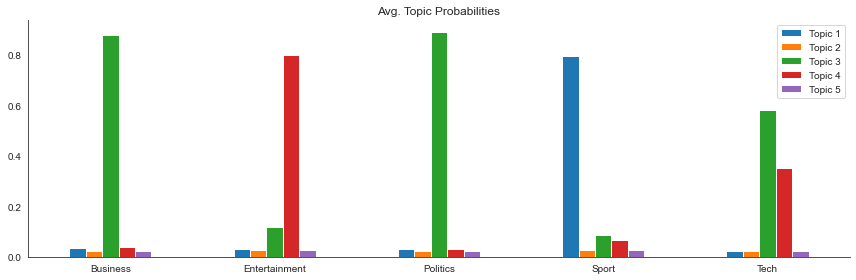

In [29]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities',
                                                 figsize=(12, 4),
                                                 rot=0)
plt.xlabel('')
sns.despine()
plt.tight_layout()

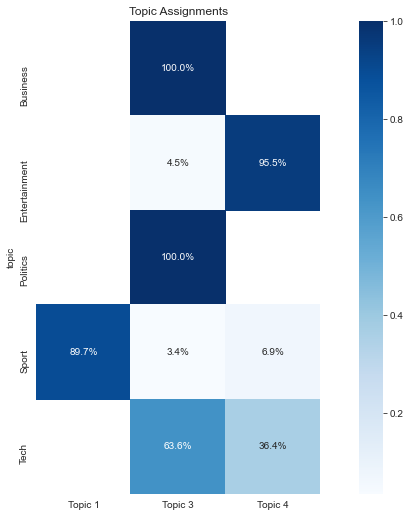

In [30]:
df = test_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True).unstack(-1), 
            annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

## Retrain until perplexity no longer decreases

In [31]:
lda_opt = LatentDirichletAllocation(n_components=5,
                                    n_jobs=-1,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=5,
                                    verbose=1,
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 5374.7526
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 5090.5028
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 5054.0080
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 5041.0213
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 5034.5664
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          n_jobs=-1, random_state=42, verbose=1)

In [32]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')

['results/bbc/lda_opt.pkl']

In [33]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

In [34]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [35]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

## Compare Train & Test Topic Assignments 

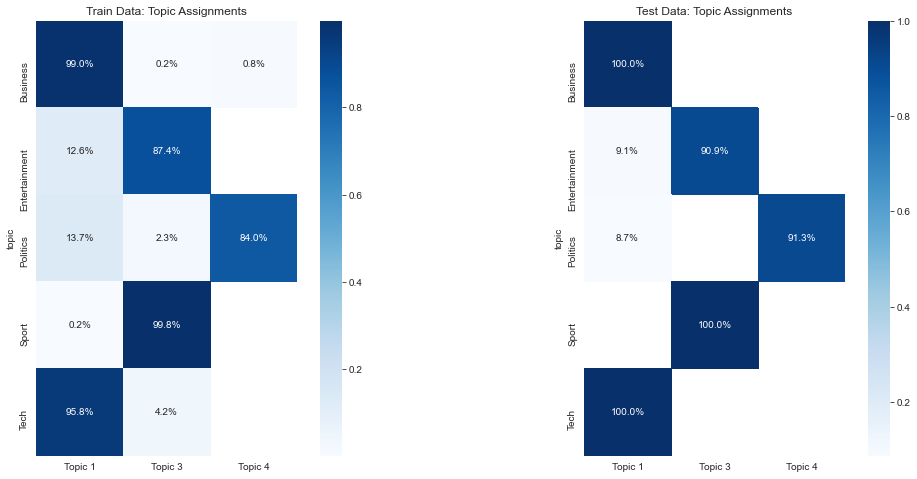

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
                .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))

## Explore misclassified articles 

In [55]:
test_assignments = test_opt_eval.groupby(level='topic').idxmax(axis=1)
test_assignments = test_assignments.reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head(50)

,topic,predicted,heading,article
0,Business,Topic 1,Kilroy launches 'Veritas' party,Ex-BBC chat show host and East Midlands MEP R...
1,Business,Topic 1,Radcliffe eyes hard line on drugs,Paula Radcliffe has called for all athletes f...
2,Business,Topic 1,S Korean consumers spending again,South Korea looks set to sustain its revival ...
3,Business,Topic 1,Quiksilver moves for Rossignol,"Shares of Skis Rossignol, the world's largest..."
4,Business,Topic 1,Britons fed up with net service,A survey conducted by PC Pro Magazine has rev...
5,Business,Topic 1,Scissor Sisters triumph at Brits,US band Scissor Sisters led the winners at th...
6,Business,Topic 1,Tory expert denies defeatism,The Conservatives' campaign director has deni...
7,Business,Topic 1,Melzer shocks Agassi in San Jose,Second seed Andre Agassi suffered a comprehen...
8,Business,Topic 1,Mobile multimedia slow to catch on,There is no doubt that mobile phones sporting...
9,Business,Topic 1,Economy focus for election battle,Britain's economic future will be at the hear...


In [38]:
misclassified = test_assignments[(test_assignments.topic == 'business') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

Series([], Name: heading, dtype: object)

In [39]:
misclassified.article.tolist()

[]

## PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

Topic visualization facilitates the evaluation of topic quality using human judgment. pyLDAvis is a python port of LDAvis, developed in R and D3.js. We will introduce the key concepts; each LDA implementation notebook contains examples.

pyLDAvis displays the global relationships among topics while also facilitating their semantic evaluation by inspecting the terms most closely associated with each individual topic and, inversely, the topics associated with each term. It also addresses the challenge that terms that are frequent in a corpus tend to dominate the multinomial distribution over words that define a topic. LDAVis introduces the relevance r of term w to topic t to produce a flexible ranking of key terms using a weight parameter 0<=ƛ<=1. 

With $\phi_{wt}$  as the model’s probability estimate of observing the term w for topic t, and   as the marginal probability of w in the corpus:
$$r(w, k | \lambda) = \lambda \log(\phi_{kw}) + (1 − \lambda) \log \frac{\phi_{kw}}{p_w}$$

The first term measures the degree of association of term t with topic w, and the second term measures the lift or saliency, i.e., how much more likely the term is for the topic than in the corpus. 

The tool allows the user to interactively change ƛ to adjust the relevance, which updates the ranking of terms. User studies have found that ƛ=0.6 produces the most plausible results. 

## Refit using all data

In [40]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [41]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1036.6739
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1034.0495
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1033.2341
iteration:

LatentDirichletAllocation(evaluate_every=10, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

In [42]:
joblib.dump(lda_all, model_path /'lda_all.pkl')

['results/bbc/lda_all.pkl']

In [43]:
lda_all = joblib.load(model_path / 'lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [44]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.069615  0.052014       1        1  30.791906
3      0.004624 -0.114806       2        1  22.890616
2      0.193820 -0.004663       3        1  20.458475
1     -0.108541  0.168193       4        1  15.589063
0     -0.159517 -0.100738       5        1  10.269940, topic_info=          Term         Freq        Total Category  logprob  loglift
1203        mr  2987.000000  2987.000000  Default  30.0000  30.0000
405    company   677.000000   677.000000  Default  29.0000  29.0000
1025    labour   770.000000   770.000000  Default  28.0000  28.0000
728       film   839.000000   839.000000  Default  27.0000  27.0000
1208     music   810.000000   810.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
283   business   123.119682   386.230263   Topic5  -5.4726   1.1327
1822      told   141.396865   904.836094   Topic5  -5.3341   0.4198
206       bank   115.958418   360.365538   Topic5  -5.5325   1.1421
1084    london   117.264384   454.835103   Topic5  -5.5213   0.9204
1228      news   115.733343   510.509978   Topic5  -5.5344   0.7918

[357 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.310466      000
0         2  0.211167      000
0         3  0.016340      000
0         4  0.331834      000
0         5  0.130723      000
...     ...       ...      ...
1992      4  0.231871    years
1992      5  0.079643    years
1993      4  0.989479      yen
1997      5  0.990858  yugansk
1998      5  0.996523    yukos

[726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1])

## Topics as WordClouds

In [45]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

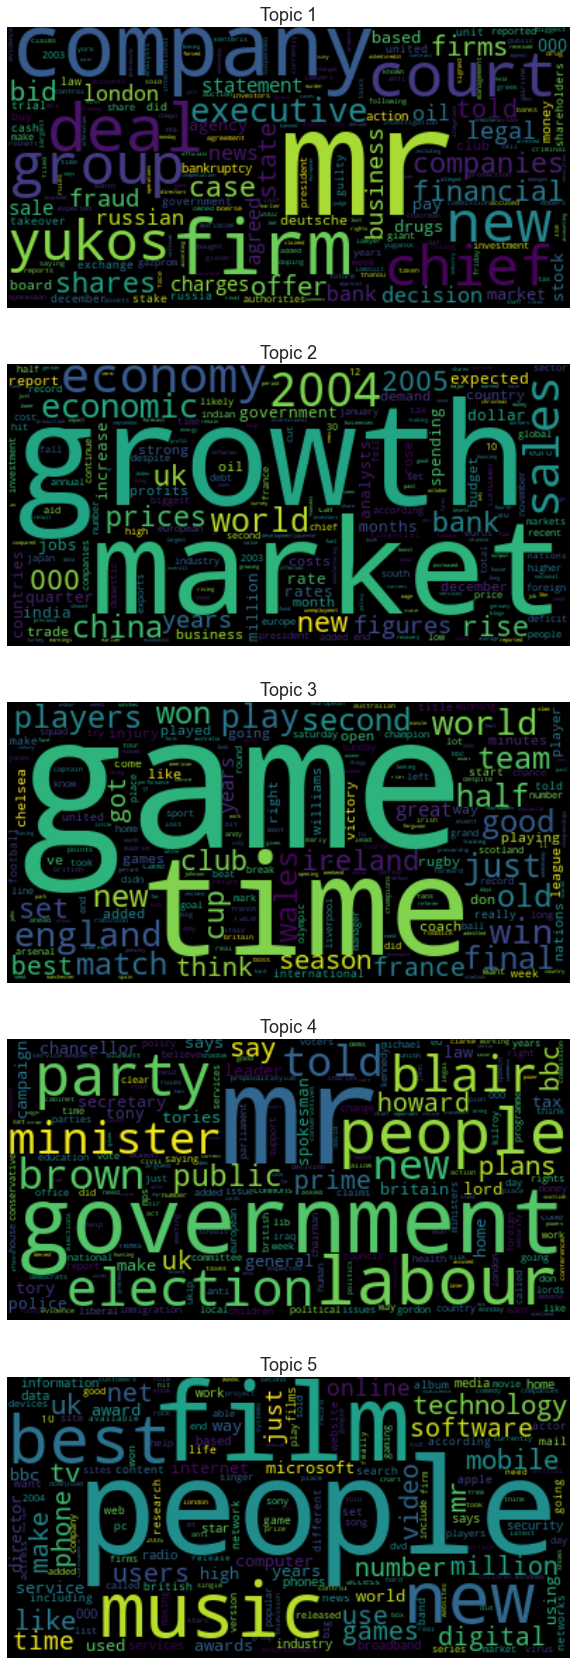

In [46]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [47]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [48]:
dtm_.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.217278,0.559808,0.001364,0.001375,0.220175
Business,0.001366,0.929723,0.001361,0.066198,0.001353
Business,0.992347,0.001911,0.001914,0.001910,0.001918
Business,0.001388,0.994458,0.001398,0.001375,0.001381
Business,0.566180,0.425551,0.002779,0.002776,0.002714


In [49]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [50]:
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.05).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
Business,0.559255,0.222441,0.064607,0.055627,0.098070,One of Japan's best-known businessmen was arr...,Japanese mogul arrested for fraud
Business,0.152645,0.519815,0.124709,0.119207,0.083624,As the Aurora limped back to its dock on 20 J...,Market unfazed by Aurora setback
Business,0.154587,0.419691,0.252344,0.075689,0.097689,Choking traffic jams in Beijing are prompting...,Beijingers fume over parking fees
Entertainment,0.215290,0.098103,0.150829,0.392351,0.143427,Proposals to open a museum dedicated to Jimi ...,Row threatens Hendrix museum plan
Entertainment,0.088833,0.179700,0.056604,0.449340,0.225522,Musicians' groups are to tackle US visa regul...,Musicians to tackle US red tape
Politics,0.222885,0.104102,0.092383,0.357693,0.222937,A group of MPs and peers has called for a tig...,Sport betting rules in spotlight
Tech,0.051874,0.173109,0.087102,0.113349,0.574566,"Dublin's hi-tech research laboratory, Media L...",Dublin hi-tech labs to shut down


In [51]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Japanese mogul arrested for fraud 

One of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data. Yoshiaki Tsutsumi was once ranked as the world's richest man and ran a business spanning hotels, railways, construction and a baseball team. His is the latest in a series of arrests of top executives in Japan over business scandals. He was taken away in a van outside one of his Prince hotels in Tokyo. There was a time when Mr Tsutsumi seemed untouchable. Inheriting a large property business from his father in the 1960s, he became one of Japan's most powerful industrialists, with close connections to many of the country's leading politicians. He used his wealth and influence to bring the Winter Olympic Games to Nagano in 1998. But last year, he was forced to resign from all the posts he held in his business empire, after being accused of falsifying the shar